# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [4]:
pip install pandas requests lxml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install html5lib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import io

 PASO 1: DESCARGAR EL HTML

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
#aplicamos el herader àra poder escrapear.
response = requests.get(url, headers=headers)

print("Estado de la petición:", response.status_code)

Estado de la petición: 200


In [8]:
html_buffer = io.StringIO(response.text)

PASO 2: EXTRAER TABLAS HTML

In [9]:
tables = pd.read_html(html_buffer)
print(f"Tablas encontradas: {len(tables)}")
songs_df = tables[0]

Tablas encontradas: 26


PASO 3: LIMPIEZA DE DATOS

In [11]:
songs_df.columns = ["rank", "song", "artist", "streams_billions", "release_date", "reference"]

songs_df["song"] = songs_df["song"].str.replace(r"\[.*?\]", "", regex=True)
songs_df["artist"] = songs_df["artist"].str.replace(r"\[.*?\]", "", regex=True)

songs_df = songs_df[
    songs_df["streams_billions"]
    .astype(str)
    .str.match(r"^\d+(\.\d+)?$")
].copy()

songs_df["streams_billions"] = songs_df["streams_billions"].astype(float)
songs_df["release_date"] = pd.to_datetime(songs_df["release_date"], errors="coerce")

Paso 4: SQlite

In [13]:
conn = sqlite3.connect("spotify_top_songs.db")

songs_df.to_sql("most_streamed_songs", conn, if_exists="replace", index=False)

cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM most_streamed_songs")
print("Filas insertadas:", cursor.fetchone()[0])

conn.commit()
conn.close()

Filas insertadas: 100


PASO 5: VISUALIZACIONES

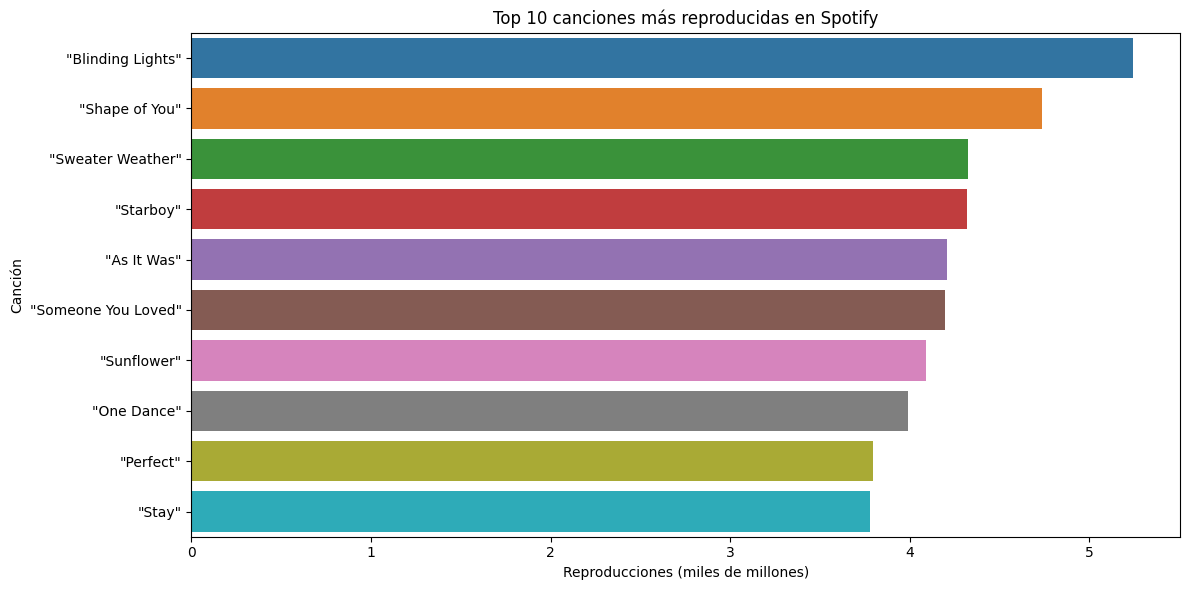

In [14]:
# Gráfico 1: Top 10 canciones más reproducidas
top_10_songs = songs_df.nlargest(10, "streams_billions")
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_songs, x="streams_billions", y="song", hue="song", legend=False)
plt.title("Top 10 canciones más reproducidas en Spotify")
plt.xlabel("Reproducciones (miles de millones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

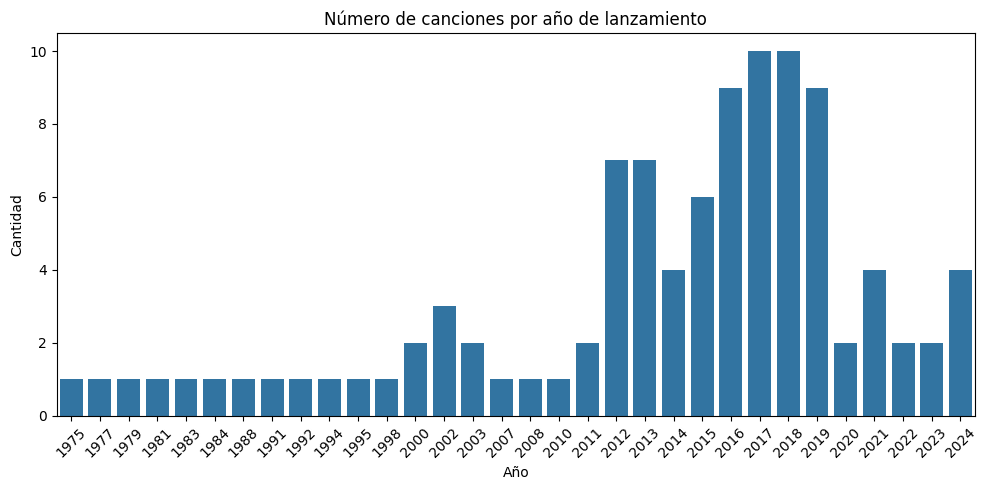

In [15]:
# Gráfico 2: Número de canciones por año
songs_df["release_year"] = songs_df["release_date"].dt.year
plt.figure(figsize=(10, 5))
sns.countplot(data=songs_df, x="release_year", order=sorted(songs_df["release_year"].dropna().unique()))
plt.title("Número de canciones por año de lanzamiento")
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

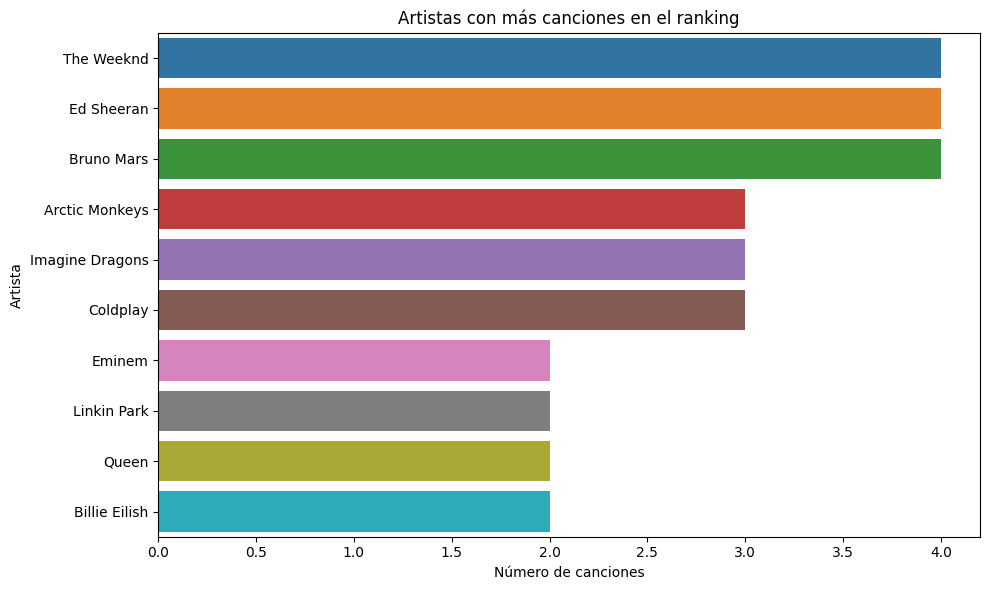

In [16]:
# Gráfico 3: Artistas con más canciones en el ranking
top_artists = songs_df["artist"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top_artists.values,
    y=top_artists.index,
    hue=top_artists.index,
    legend=False
)
plt.title("Artistas con más canciones en el ranking")
plt.xlabel("Número de canciones")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()